In [12]:
import matplotlib
from matplotlib import pyplot as plt
import igraph as ig
import geopandas as gpd
from tqdm import tqdm
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import os
from pathlib import Path

In [20]:
DATA_FOLDER_PATH = Path('../data/Boston')
SCENARIO_FOLDER_PATH = DATA_FOLDER_PATH / 'scenarios'

problem_graph_file = DATA_FOLDER_PATH / 'resulting_graph/Boston_problem_graph_2024-11-21_reduced.gml'
complete_census_file = DATA_FOLDER_PATH / 'complete_census_2022.parquet'
crs = "EPSG:4326"

In [45]:
g : ig.Graph = ig.read(problem_graph_file)
complete_census = gpd.read_parquet(complete_census_file)
complete_census = complete_census.to_crs(crs)

In [15]:
pt_nodes = g.vs.select(type='pt_node')
subgraph = g.subgraph(pt_nodes)
adj_matrix = subgraph.get_adjacency()

In [16]:
# Filter vertices by type
pt_nodes = g.vs.select(type='pt_node')

# Filter 'METRO' edges and create a subgraph
metro_edges = g.es.select(type='METRO')
metro_subgraph = g.subgraph_edges(metro_edges, delete_vertices=True)
undirected_metro_graph = metro_subgraph.as_undirected(combine_edges='first')

# Normalize the 'tt' values for colormap mapping
tt_values = [edge['tt'] for edge in undirected_metro_graph.es]
norm = mcolors.Normalize(vmin=min(tt_values), vmax=max(tt_values))
cmap = plt.get_cmap('viridis')  # Use the viridis colormap

In [17]:
# get the link from undirected_metro_graph
# get the link from undirected_metro_graph
edges = undirected_metro_graph.es
edges[1]

igraph.Edge(<igraph.Graph object at 0x7077959d8240>, 1, {'weight': 2.0, 'name': 'Red_mbta_1', 'type': 'METRO', 'uniqueagencyid': 'mbta', 'tt': 2.0, 'uniquerouteid': 'Red_mbta', 'routetype': 1.0, 'color': 'BLACK', 'active': 1.0})

In [21]:
adj_matrix = undirected_metro_graph.get_adjacency().data

# Extract the names of the vertices
vertex_names = [v['name'] for v in undirected_metro_graph.vs]

# Create a pandas DataFrame with vertex names as row and column labels
adj_matrix_df = pd.DataFrame(adj_matrix, index=vertex_names, columns=vertex_names)

# Display the adjacency matrix with labels
# print(adj_matrix_df)
adj_matrix_df.to_csv(SCENARIO_FOLDER_PATH / 'scenario_100.csv')

In [48]:
# Define the directory and file names
file_names = [
    'scenario_0_1.csv',
    'scenario_1.csv',
    'scenario_5.csv',
    'scenario_10.csv',
    'scenario_50.csv',
    'scenario_100.csv'
]

# Read each file into a dataframe and store it in a dictionary
dataframes = {}
for file_name in file_names:
    file_path = SCENARIO_FOLDER_PATH / file_name
    dataframes[file_path.stem] = pd.read_csv(file_path, index_col=0)
    # dataframes[file_name.stem].to_csv(file_path.parent / (file_path.stem.replace('adj_matrix', 'scenario') + '.csv'), index=True)

In [50]:
def plot_interdiction_map(interdiction_scenario_adj_matrix_df, g, complete_census, penalty=99, ax=None):
    # Filter vertices by type
    rc_nodes = g.vs.select(type='rc_node')
    pt_nodes = g.vs.select(type='pt_node')
    
    if not ax:
        # First plot: Plot only 'rc_node' vertices
        fig, ax = plt.subplots(figsize=(10, 10))
    
    _ = ig.plot(
        g.subgraph(rc_nodes),
        target=ax,
        vertex_size=2,
        vertex_color='black',
        vertex_label=None,  # Hide vertex labels
        edge_color=None,  # Hide edges
        edge_width=0
    )
    
    # Get the extent (bounds) of the base map
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # Second plot: Plot only 'pt_node' vertices with 'METRO' edges
    metro_edges = g.es.select(type='METRO')
    metro_subgraph = g.subgraph_edges(metro_edges, delete_vertices=True)
    undirected_metro_graph = metro_subgraph.as_undirected(combine_edges='first')
    
    # Adapt the 'tt' values in the interdiction scenario to the 'METRO' edges
    for edge in undirected_metro_graph.es:
        edge['tt'] = penalty * interdiction_scenario_adj_matrix_df.loc[edge.source['name'], edge.target['name']]
    
    edge_plot = ig.plot(
        undirected_metro_graph,
        target=ax,
        vertex_size=8,
        vertex_color='blue',  # Color for 'pt_node' vertices
        vertex_label=None,  # Hide vertex labels
        edge_width=4,
        arrows=False,
        arrow_size=0
    )
    
    # Normalize the 'tt' values for colormap mapping
    tt_values = [edge['tt'] for edge in undirected_metro_graph.es]
    norm = mcolors.Normalize(vmin=min(tt_values), vmax=max(tt_values))
    cmap = plt.get_cmap('viridis')  # Use the viridis colormap
    
    # Extract the edge collection and apply the color mapping
    edge_collection = [e for e in edge_plot.get_children() if isinstance(e, ig.drawing.matplotlib.edge.EdgeCollection)][0]
    colors = [cmap(norm(tt)) for tt in tt_values]
    edge_collection.set_edgecolor(colors)
    edge_collection.set_alpha(1)
    
    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.1)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for colorbar
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label('Travel Time (tt)', rotation=270, labelpad=20)
    
    # Plot census boundaries
    complete_census.boundary.plot(ax=ax, edgecolor="gray", alpha=0.3)
    
    # Ensure limits match base map extent
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.set_title("Boston Metro Network with 45 minute RC and POI Nodes")
    
    return ax

TypeError: plot_interdiction_map() got an unexpected keyword argument 'ax'

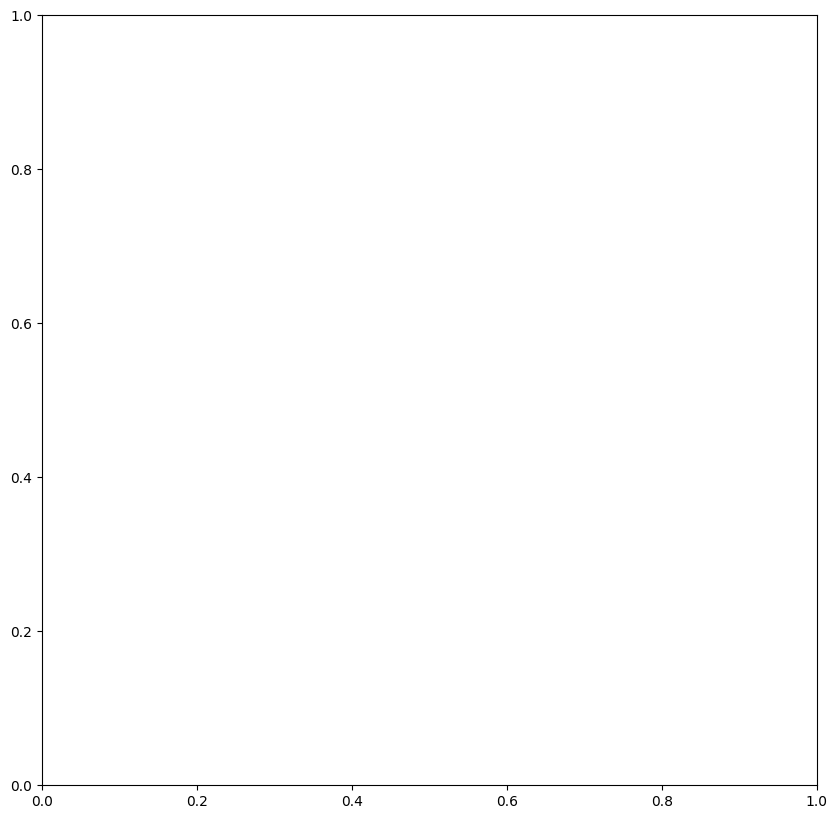

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
interdiction_scenario_adj_matrix_df = dataframes['scenario_100']
plot_interdiction_map(interdiction_scenario_adj_matrix_df, g, complete_census, penalty=99, ax=ax)

In [ ]:
# Plot each scenario in a 2 x 3 grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
